# PROJECT 2 : Part 3
## Ames Housing Data and Kaggle Challenge

### Model Preparation, Training, Selection, and Testing
This notebook will focus on the above listed. This is a continuation from Part 2 where features were analysed and then selected for model training in predicting SalePrice. 

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.dummy import DummyRegressor

A toal of 7 features have been selected for the model training process.

In [2]:
# Load data
train_feat = pd.read_csv('datasets/train_feat.csv')


#### Model prep: Create features matrix (X) and target vector (y)

In [3]:
# Define X and y
X = train_feat.loc[:, train_feat.columns != 'SalePrice']
y = train_feat['SalePrice']

####  Model prep: Train/ Test split

In [4]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10) #train_size=0.7

#### Model prep: Scaling

In [5]:
# Scale X_train and transform bot X_train and X_test

ss= StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

#### Model prep: Instantiate models

In [6]:
# Set lasso and ridge
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

#### Cross validation

In [7]:
# Cross val score for lr fitted to train data
lr_scores = cross_val_score(lr, X_train_sc, y_train, cv=3)
lr_scores.mean()

0.7669461904380771

In [8]:
# Cross val score for LassoCV fitted to train data
lasso_scores = cross_val_score(lasso, X_train_sc, y_train, cv=3)
lasso_scores.mean()

0.7679337571497946

In [9]:
#Cross val score for RidgeCV fitted to train data
ridge_scores = cross_val_score(ridge, X_train_sc, y_train, cv=3)
ridge_scores.mean()

0.7673676710872562

All 3 models returned results that are very close, with the lasso model scoring the highest. 

#### Establish Null model

In [10]:
dummy_regr= DummyRegressor(strategy='mean')

In [11]:
dummy_regr.fit(X,y)

DummyRegressor()

In [12]:
dummy_regr.predict(X)

array([181484.25244141, 181484.25244141, 181484.25244141, ...,
       181484.25244141, 181484.25244141, 181484.25244141])

In [13]:
dummy_regr.score(X,y)

0.0

### Model Fitting and Evaluation

In [14]:
lasso.fit(X_train_sc, y_train)

LassoCV(n_alphas=200)

In [15]:
lasso.score(X_train_sc, y_train)

0.7793606892663202

In [16]:
lasso.score(X_test_sc,y_test)

0.8002952648735654

In [17]:
lasso_scores.mean()

0.7679337571497946

In [18]:
pred = lasso.predict(X_test_sc)

In [19]:
r2_score(y_test, pred)

0.8002952648735654

In [20]:
# Create df for strong coefficients and their corresponding variable names
coefficient_df = pd.DataFrame()

In [21]:
# Sorting all the column names of the predictors
coefficient_df['Column_Name'] = X_train.columns

In [22]:
# Store coefficients of predictors
coefficient_df['Coefficient_Value'] = pd.Series(lasso.coef_)

In [23]:
# Preview variables' coefficient values
print(coefficient_df)

     Column_Name  Coefficient_Value
0   Overall Qual       29721.465031
1    Gr Liv Area       18810.707887
2    Garage Area        6087.543338
3    Garage Cars        7610.257795
4  Total Bsmt SF           0.000000
5     1st Flr SF       11369.057118
6      Bsmt Qual       11970.863787


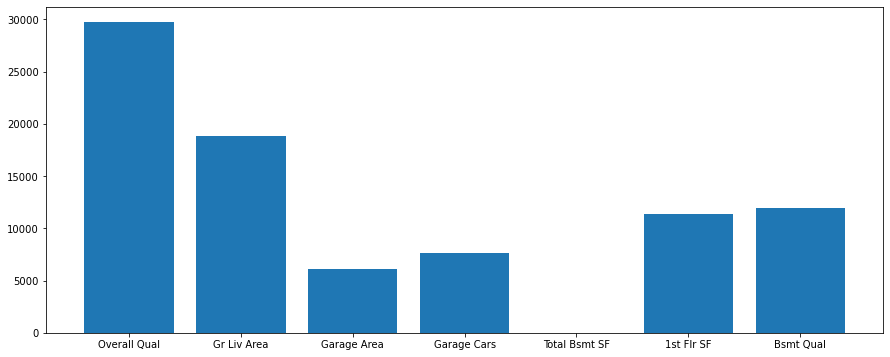

In [24]:
# Plot the coefficient values
plt.rcParams['figure.figsize'] = (15,6)
plt.bar(coefficient_df['Column_Name'], coefficient_df['Coefficient_Value']);

The final test scored returned a 0.8. From the bar graph above, it is clear to see which variable was shrunk by the Lasso Regression as it was weak. Total Bsmt SF can br dropped to improve model performance in the next run. 

Null model indicates a baseline where the model must score better with. The current lasso regression model score is at 0.80, which is better than the null model's score. 

## Test Data
Load, clean, transform and test against model with the test.csv data

In [25]:
# Load data
testdf = pd.read_csv('datasets/test.csv')

As the features need to be consistent, narrowing the test data to just the selected features from the train data would be more efficient. 

In [26]:
features = [ 'Overall Qual', 'Gr Liv Area', 'Garage Area', 'Garage Cars', 'Total Bsmt SF', '1st Flr SF', 'Bsmt Qual']

In [27]:
test_feat = testdf.loc[:,features]

In [28]:
# Check for null values
null_stats = pd.DataFrame(test_feat.isnull().sum(), columns = ['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count']/test_feat.shape[0]*100,2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count',ascending=False)

,missing_value_count,% of dataset
Bsmt Qual,25,2.85


In [29]:
# Investigate the types of value under each object-type columns
test_feat['Bsmt Qual'].value_counts()

TA    396
Gd    355
Ex     73
Fa     28
Po      1
Name: Bsmt Qual, dtype: int64

Bsmt Qual, being a ordinal data type, will have its missing values replaced with the same rating values used in the train data set. 

In [30]:
# Replace Bsmt Qual values with appropriate rating values.
replace = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, np.NaN :0}
test_feat['Bsmt Qual'] = test_feat['Bsmt Qual'].map(replace)

In [31]:
# Check for null values
null_stats = pd.DataFrame(test_feat.isnull().sum(), columns = ['missing_value_count'])
null_stats.loc[:,'% of dataset'] = np.round(null_stats.loc[:,'missing_value_count']/test_feat.shape[0]*100,2)
null_stats.loc[null_stats.loc[:,'missing_value_count']>0,:].sort_values(by='missing_value_count',ascending=False)

,missing_value_count,% of dataset


The data is cleaned and the features are selected. 

#### Predict with trained model

In [32]:
# Define X variable
testX = test_feat

In [33]:
# Scale it
testX = ss.transform(testX)

In [34]:
# Predict using model
pred = lasso.predict(testX)

In [35]:
pred

array([158596.27308318, 210462.30903786, 192642.4253383 , 127914.90206092,
       191441.79559527,  83975.55551688, 100387.60252137, 144689.86136349,
       209242.33865628, 169248.10073169, 178838.96886365, 149024.03532932,
       174992.5717755 , 300352.76614988, 165629.49365782,  95899.38077675,
       173896.70235779, 120863.77697352, 200467.48104718, 216584.48258663,
       118005.53198444, 128195.8558009 , 206784.11609521, 151844.08102117,
       202419.29480628, 107334.3363389 , 131750.81821876, 130524.73437247,
       154514.19581187,  26048.45233534,  95508.72176195, 114270.4966667 ,
       273673.69520722, 154076.33401373, 221517.10868962, 190400.30773114,
       118976.73799586,  68267.62120529, 122183.99182124, 213108.01407112,
       162939.24459983, 215848.32059631, 155846.91821703, 138629.0165767 ,
       219377.86565633,  82519.0658291 , 216099.27057491, 112555.4802278 ,
       110858.77321111, 117761.3443978 , 117674.64164137, 235599.74412804,
       267898.89398324, 1

In [36]:
# Store predictions
testdf['SalePrice'] = list(pred)

In [37]:
# Store in new df for kaggle submission
pred_test = testdf.loc[:,['Id','SalePrice']]

In [38]:
# Save df as csv
pred_test.to_csv('datasets/pred_test.csv', index=False)